# Definition

- 미국 SnP 500의 추세를 확인하고, PCA 분석을 통해 흐름을 주도하는 주요인을 확인힌다.

## package 세팅 및 데이터 세팅

### 패키지

In [1]:
!pip install scikit-learn
!pip install yfinance
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# import FinanceDataReader as fdr
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')


### help function

In [3]:
# def write_from_fdr(symbols, start_date = "2010-01-01", return_erros=False):

#     end = datetime.today().strftime("%Y-%m-%d")
#     prices = pd.DataFrame()
#     errors = []
#     for ticker in symbols:
#         try:
#             price = fdr.DataReader(ticker, start_date, end).assign(ticker=ticker)
#             prices = pd.concat([prices, price], axis=0)
#         except:
#             errors.append(ticker)
#     if return_erros:
#         return prices, errors
#     return prices

def write_from_yf(symbols, market, start_date = "2019-01-01", return_erros=False):

    end = datetime.today().strftime("%Y-%m-%d")
    prices = pd.DataFrame()
    errors = []
    for ticker in snp500_stocks.Symbol:
        try:
            price = yf.download(ticker, start=start_date, end=end).assign(ticker=ticker)
            prices = pd.concat([prices, price], axis=0)
        except:
            errors.append(ticker)
    return prices

In [4]:
def clip_returns(returns):
    normed_returns = scale(returns
                        .clip(lower=returns.quantile(q=.025),
                              upper=returns.quantile(q=.975),
                              axis=1)
                        .apply(lambda x: x.sub(x.mean()).div(x.std())))
    returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
    returns = returns.dropna(thresh=int(returns.shape[1] * .95))
    # returns.info()
    return returns

### 데이터 준비
- 기본적으로 연간 데이터를 기반으로 분석합니다.
- period_start와 period_end를 지정하면 기간 분석을 수행 합니다.
  - period_start: 2023, period_end: 2023이라면 2023년 1년 기간입니다.
  - period_start: 2020, period_end: 2021이라면 2020-2021년 2년 기간입니다.
- stock_range는 분석을 실시한 stock의 수이고, 시가총액 상위 순서로 지정 합니다.   
  - 50이라면 시가총액 상위 50개를 지정합니다.

In [5]:
stock_range = 50  #계산에 사용할 stock의 수
period_start = '2023'
period_end = '2023'

#### 데이터 다운로드

In [6]:
snp500_stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)[0]
snp500_stocks.Symbol = snp500_stocks.Symbol.apply(lambda x: x.replace('.','-'))

In [7]:
prices = write_from_yf(snp500_stocks.Symbol, market="s&p500",start_date=f'{period_start}-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
prices = prices.reset_index().set_index(['Date','ticker'])

In [9]:
market_cap = {ticker : yf.Ticker(ticker).get_info()['marketCap'] for ticker in  snp500_stocks.Symbol}
market_cap = pd.DataFrame(market_cap.values(),index = market_cap.keys(), columns=['cap']).sort_values(by='cap', ascending=False)
market_cap = market_cap.drop(index='GOOG')

#### return 계산

##### 시가 총액 기준 상위: 현재 기준

In [10]:
idx = pd.IndexSlice
cols = market_cap[:stock_range].index
len(cols)

50

In [11]:
returns = prices.loc[idx[:, cols],'Adj Close'].unstack('ticker').pct_change()
# returns.info()
returns = returns[period_start:period_end]

In [12]:
columns = {ticker:name for ticker, name in zip(snp500_stocks.Symbol	, snp500_stocks.Security)}
returns = returns.rename(columns=columns)
returns = clip_returns(returns)

## 데이터 분석

### cov 클러스터맵
- 각 stock의 상관 관계를 표시

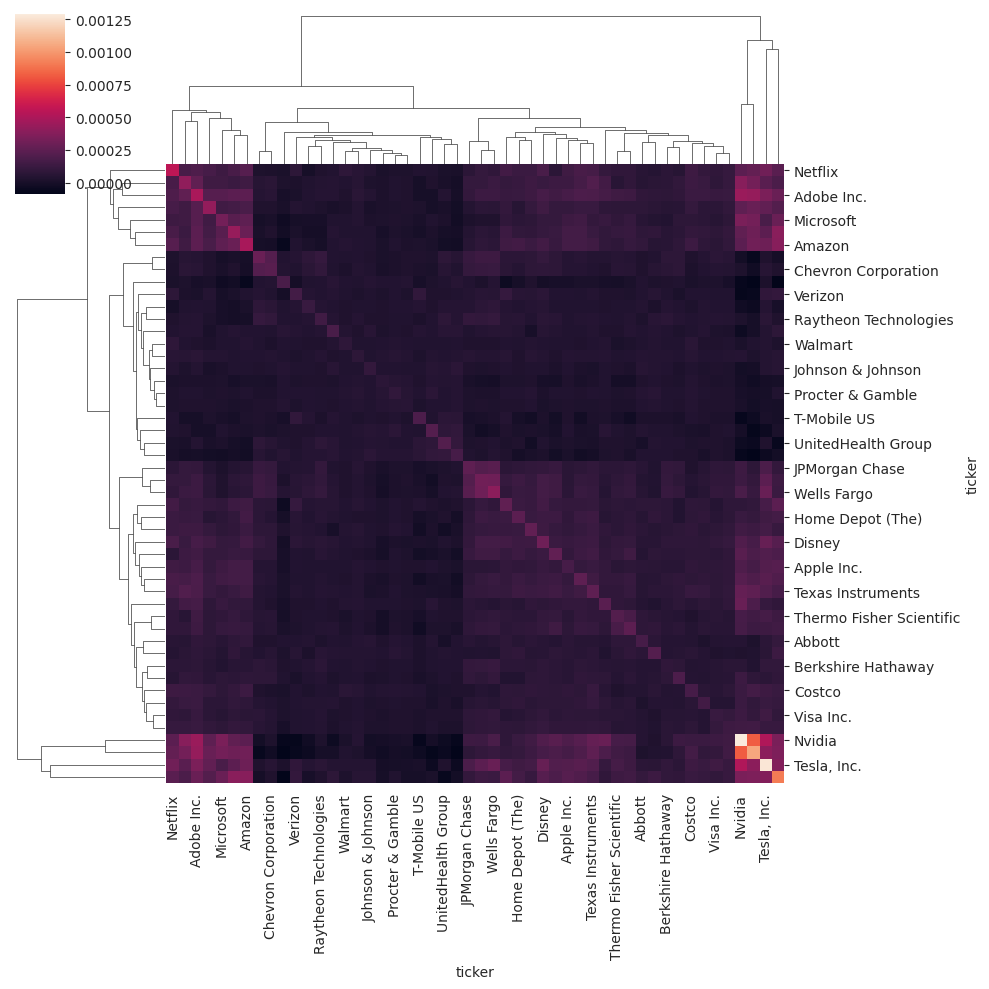

In [13]:
cov = returns.cov()
sns.clustermap(cov)

### PCA 분석 후 component별 비중
- 설명력이 높은 PCA의 components에서 weight가 높은 stock이 시장에 큰 영향을 준다.

In [14]:
pca = PCA()
pca.fit(cov)
explained_variance = pd.Series(pca.explained_variance_ratio_, index=range(1, len(pca.explained_variance_ratio_) + 1))
explained_variance.head().to_frame('Explained Variance').style.format('{:,.2%}'.format)


,Explained Variance
1,70.80%
2,8.78%
3,7.12%
4,3.58%
5,1.76%


In [15]:
# Create top4 dataframe
top4 = pd.DataFrame(pca.components_[:5], columns=cov.columns)

# Normalize eigen portfolios
eigen_portfolios = top4.div(top4.sum(1), axis=0)

# Rename index
eigen_portfolios.index = [f'Portfolio {i+1}' for i in range(5)]

# Create subplots with 5 rows and 1 columns
fig = make_subplots(
    rows=5,
    cols=1,
    subplot_titles=eigen_portfolios.index,
    vertical_spacing=0.11,  # 수정된 간격
)

# Iterate over each eigen portfolio and create a bar trace
for i, portfolio in enumerate(eigen_portfolios.index):
    row = i + 1
    col = 1

    # Add a bar trace for each eigen portfolio
    fig.add_trace(
        go.Bar(
            x=eigen_portfolios.columns,
            y=eigen_portfolios.loc[portfolio],
            name=portfolio,
            hovertemplate='x: %{x}<br>y: %{y:.1%}',  # x축 라벨과 y축 표시 값을 백분율 형식으로 변경하여 hovertemplate 설정
        ),
        row=row,
        col=col,
    )

    # Rotate x-axis labels
    fig.update_xaxes(row=row, col=col, showgrid=True, gridwidth=1, gridcolor='lightgray')  # 보조선 추가

    # Update yaxis tickformat
    fig.update_yaxes(tickformat='.0%', row=row, col=col)  # 모든 그래프의 y축 레이블에 % 기호 표시

# Update layout
fig.update_layout(
    height=2000,
    title_text='Eigen Portfolios',
    showlegend=False,
    barmode='stack',
)

# Show the plot
fig.show()


### PCA component별 수익률
- 시장(The market)을 기준으로 각 Porfolio가 어떻게 움직였는지 알 수 있다.
- 각 Porfolio를 모두 합하면 시장(The market)이 될 수 있다.
- Porfolio는 시장의 성향이라고 볼 수 있다.

In [16]:
# Create subplots with 6 rows and 1 columns
fig = make_subplots(
    rows=6,
    cols=1,
    subplot_titles=('The Market', 'Portfolio 1', 'Portfolio 2', 'Portfolio 3', 'Portfolio 4', 'Portfolio 5'),
    shared_xaxes=False,
)

# Plot Portfolios
for i in range(6):  # 수정된 부분
    if i == 0:
        # Plot The Market
        fig.add_trace(
            go.Scatter(x=returns.index, y=returns.mean(1).add(1).cumprod().sub(1), mode='lines', line=dict(width=1)),
            row=i+1,
            col=1
        )
        fig.update_yaxes(title_text='Return', tickformat='.0%', row=1, col=1)
    else:
        rc = returns.mul(eigen_portfolios.iloc[i - 1]).sum(1).add(1).cumprod().sub(1)
        fig.add_trace(
            go.Scatter(x=returns.index, y=rc, mode='lines', line=dict(width=1)),
            row=i+1,
            col=1
        )

for i in range(6):  # 수정된 부분
    fig.update_yaxes(title_text='Return', tickformat='.1%', row=i, col=1)

# Update layout
fig.update_layout(
    height=1500,
    width=800,
    title_text='Return of Portfolios',
    showlegend=False,
)

# Show the plot
fig.show()


### PCA component별 수익률 (정상성 제거)
- 시계열성을 제거한 수익률이다.
- 각 시점의 변동성을 확인할 수 있다.

In [17]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 5 rows and 1 columns
fig = make_subplots(
    rows=6,
    cols=1,
    subplot_titles=('The Market', 'Portfolio 1', 'Portfolio 2', 'Portfolio 3', 'Portfolio 4', 'Portfolio 5'),
    shared_xaxes=False,
)

# Plot Portfolios
for i in range(6):
    if i == 0:
      fig.add_trace(
      go.Bar(x=returns.index, y=returns.mean(1).add(1).cumprod().sub(1).diff(), name='The Market', marker=dict(color='steelblue')),
      row=i+1,
      col=1)
    else:
      rc = returns.mul(eigen_portfolios.iloc[i-1]).sum(1).add(1).cumprod().sub(1).diff()
      fig.add_trace(
          go.Bar(x=returns.index, y=rc, name=f'Portfolio {i}',marker=dict(color='steelblue')),
          row=i+1,
          col=1
      )

# Update axis labels and tick format
fig.update_yaxes(title_text='Return', tickformat='.0%', row=1, col=1)

for i in range(6):
    fig.update_yaxes(title_text='Return', tickformat='.1%', row=i, col=1)

# Update layout
fig.update_layout(
    height=1500,
    width=800,
    title_text='Return of Portfolios',
    showlegend=False,
)

# Show the plot
fig.show()


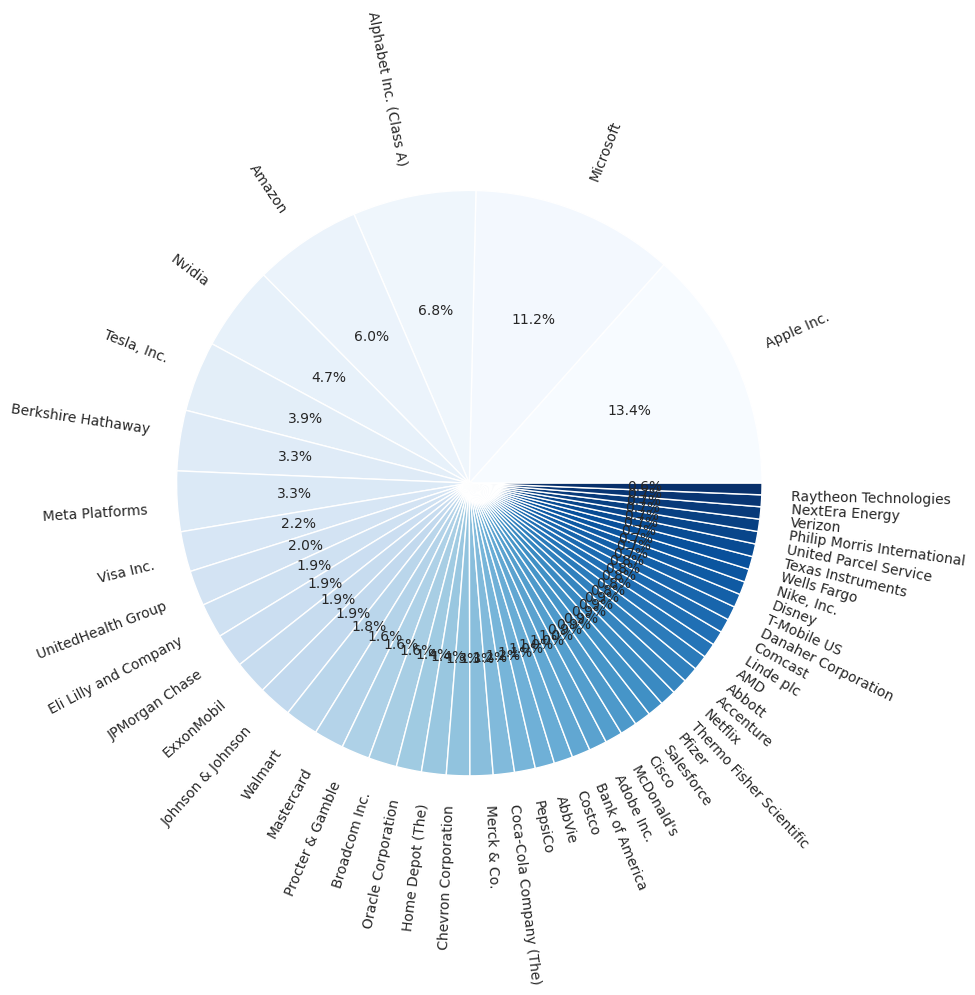

In [18]:
market_cap = market_cap.rename(index=columns)
(market_cap.sort_values(by='cap',ascending=False)/market_cap.sum())[:stock_range].plot.pie(subplots=True, legend=False,
                                                                                  figsize=(10,10), cmap='Blues',
                                                                                  autopct='%.1f%%', fontsize=10, ylabel='',rotatelabels=True)
plt.tight_layout()

---